- train on shift=1, ntrials=2, nmaps=4, trlen=?,
- eval on ntrials=2*(nmaps^2) - every possible instruction sequence twice
- assess separation against PI buildup

In [58]:
import torch as tr
import numpy as np

import itertools

from PM_models import *
from PM_tasks import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

def mov_avg(arr,wind):
  MA = -np.ones(len(arr)-wind)
  for t in range(len(arr)-wind):
    MA[t] = arr[t:t+wind].mean()
  return MA

maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# training data

In [124]:
def load_tracc(em,ntr,trlen,ntok,seed,mean='None'):
  nm=4
  fdir = 'model_data/amtask-sweep1/'
  fpath = 'lstm_20-em_%s-nmaps_%s-ntrials_%s-trlen_%s-ntoksurp_%s-seed_%s-trsc.npy'%(em,nm,ntr,trlen,ntok,seed)
  try:
    trsc = np.load(fdir+fpath)
  except:
    print('err loading',fpath)
    return None
  if mean=='None':
    return trsc.mean((1,2))
  elif mean=='final':
    return trsc[-100].mean().round(2)
    
for seed in range(10):
  tracc = load_tracc(0,1,20,50,seed,mean='final')
  print('seed',seed,'final acc',tracc)

seed 0 final acc 0.29
seed 1 final acc 1.0
seed 2 final acc 0.46
seed 3 final acc 0.29
seed 4 final acc 0.29
seed 5 final acc 0.46
seed 6 final acc 0.25
seed 7 final acc 0.38
seed 8 final acc 0.38
seed 9 final acc 0.42


In [ ]:
emL = [0,1]
ntrL = [1,2]
trlenL = [20,30,40]
ntokL = [0,50]

xaxL = []
accL = []
for idx,(em,ntok,ntr,trlen) in enumerate(itertools.product(emL,ntokL,ntrL,trlenL)):
  acc = []
  for seed in range(20):
    acc_net = load_tracc(em,ntr,trlen,ntok,seed,mean='final')
    if type(acc_net)==type(None): continue
    acc.append(acc_net)
  xaxL.append((em,ntok,ntr,trlen))
  accL.append(np.array(acc))


err loading lstm_20-em_0-nmaps_4-ntrials_1-trlen_20-ntoksurp_50-seed_14-trsc.npy
err loading lstm_20-em_0-nmaps_4-ntrials_1-trlen_20-ntoksurp_50-seed_15-trsc.npy
err loading lstm_20-em_0-nmaps_4-ntrials_1-trlen_20-ntoksurp_50-seed_16-trsc.npy
err loading lstm_20-em_0-nmaps_4-ntrials_1-trlen_20-ntoksurp_50-seed_17-trsc.npy
err loading lstm_20-em_0-nmaps_4-ntrials_1-trlen_20-ntoksurp_50-seed_18-trsc.npy
err loading lstm_20-em_0-nmaps_4-ntrials_1-trlen_20-ntoksurp_50-seed_19-trsc.npy
err loading lstm_20-em_0-nmaps_4-ntrials_1-trlen_30-ntoksurp_50-seed_13-trsc.npy
err loading lstm_20-em_0-nmaps_4-ntrials_1-trlen_30-ntoksurp_50-seed_14-trsc.npy
err loading lstm_20-em_0-nmaps_4-ntrials_1-trlen_30-ntoksurp_50-seed_15-trsc.npy
err loading lstm_20-em_0-nmaps_4-ntrials_1-trlen_30-ntoksurp_50-seed_16-trsc.npy
err loading lstm_20-em_0-nmaps_4-ntrials_1-trlen_30-ntoksurp_50-seed_17-trsc.npy
err loading lstm_20-em_0-nmaps_4-ntrials_1-trlen_30-ntoksurp_50-seed_18-trsc.npy
err loading lstm_20-em_0-nma

In [ ]:
[a.shape for a in accL]

In [150]:
mean_acc = [a.mean() for a in accL]
std_acc = [a.std()/np.sqrt(len(a)) for a in accL]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(0, 0, '0\n 0\n 1\n 20'),
 Text(0, 0, '0\n 0\n 1\n 30'),
 Text(0, 0, '0\n 0\n 1\n 40'),
 Text(0, 0, '0\n 0\n 2\n 20'),
 Text(0, 0, '0\n 0\n 2\n 30'),
 Text(0, 0, '0\n 0\n 2\n 40'),
 Text(0, 0, '0\n 50\n 1\n 20'),
 Text(0, 0, '0\n 50\n 1\n 30'),
 Text(0, 0, '0\n 50\n 1\n 40'),
 Text(0, 0, '0\n 50\n 2\n 20'),
 Text(0, 0, '0\n 50\n 2\n 30')]

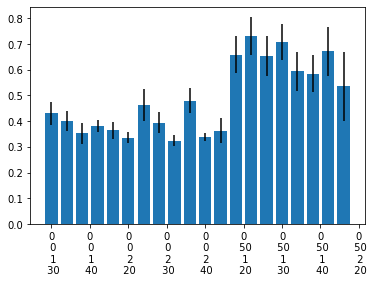

In [151]:
ax = plt.gca()

ax.bar(range(len(mean_acc)),mean_acc,yerr=std_acc)

# xtick labels
xaxLs = ["\n".join(str(i)[1:-1].split(',')) for i in xaxL]
ax.set_xticklabels(xaxLs)

In [123]:
acc

array([], dtype=float64)

### eval with vs without EM

In [110]:
def load_eval_data_subj(em,ntr,trlen,ntok,seed):
  ''' returns evacc for [em0,em1]'''
  fdir = 'model_data/amtask-sweep1_analysis/eval/'
  L = []
  for em_ev in [0,1]:
    fpath = "lstm_20-em_%i-nmaps_4-ntrials_%i-trlen_%i-ntoksurp_%i-seed_%i-em_ev_%i-evsc.npy"%(
      em,ntr,trlen,ntok,seed,em_ev)
    try:
      evacc = np.load(fdir+fpath).mean(0)
    except:
      print('not found',fpath)
      return None
    L.append(evacc)
  return np.array(L)

def load_eval_data(em,ntr,trlen,ntok,nnets=5):
  ''' loop over subs, return evacc [sub,em_ev,ntr,trlen]'''
  L = []
  for seed in range(nnets):
    evacc = load_eval_data_subj(em,ntr,trlen,ntok,seed)
    if type(evacc) == type(None): continue
    L.append(evacc)
  return np.array(L)

evacc = load_eval_data(em=0,ntr=1,trlen=20,ntok=0)
evacc.shape

(5, 2, 10, 14)

## assessing PI build-up

In [ ]:
evacc = load_eval_data(em=0,ntr=1,trlen=20,ntok=0)

### plot em reliance for each group

In [61]:
'''analysis funs'''

def compute_em_reliance(net,ntr_ev,trlen_ev,neps_ev):
  '''compute reliance on EM pathway
  difference in acc between em=1 and em=0
  '''
  nmaps=4
  task = TaskArbitraryMaps(nmaps=4,switchmaps=1,ntokens_surplus=0,seed=net.seed)
  evacc = -np.ones([2,ntr_ev,nmaps+trlen_ev])
  for em_ev in [0,1]:
    net.EMsetting = em_ev
    task = TaskArbitraryMaps(nmaps=4,switchmaps=1,ntokens_surplus=net.ntoksurp,seed=net.seed)
    evsc = run_net(net,task,neps_ev,ntr_ev,trlen_ev,training=False)
    evacc[em_ev] = evsc.mean(0)
  evac_diff = evacc[1]-evacc[0]
  return evac_diff

In [71]:
def write_note(save_fpath,note):
  with open(save_fpath,'w') as f:
    f.write(note)
    

In [76]:
''' compute em reliance for each net of each group and save data '''
note = 'em reliance is the accuracy difference between net evaled with vs without em'
fdir_save = 'model_data/amtask-sweep1_analysis/em_reliance/'
write_note(fdir_save+'analysis_note',note)

## eval params
ntr_ev,trlen_ev = 10,10
neps_ev = 200

# loop
emsettingL = [0,1]
ntrialsL = [1,2]
trlenL = [20,30,40]
toksurpL = [0]

for emsetting,ntrials,trlen,toksurp in itertools.product(emsettingL,ntrialsL,trlenL,toksurpL):
  print(emsetting,ntrials,trlen,toksurp)
  netL = load_netL(emsetting,ntrials,trlen,toksurp,nnets=20)
  for net in netL:
    net_em_r = compute_em_reliance(net,ntr_ev,trlen_ev,neps_ev)
    fpath = 'em_reliance-em_%i-ntr_%i-trlen_%i-toksurp_%i-seed_%i'%(emsetting,ntrials,trlen,toksurp,net.seed)
    np.save(fdir_save+fpath,net_em_r)


0 1 20 0
N= 20
0 1 30 0
N= 20
0 1 40 0
N= 20


KeyboardInterrupt: 

(5,)

### multi trial eval

In [145]:
netL = load_netL(emsetting=1,ntrials=1,trlen=20,nnets=20)
net = netL[2]
task = TaskArbitraryMaps(nmaps=4,switchmaps=1,ntokens_surplus=0,seed=net.seed)

N= 13


In [146]:
neps_ev = 200
nt_ev,trl_ev = 500,2
nmaps = 4
evsc = run_net(net,task,neps_ev,nt_ev,trl_ev,training=False)

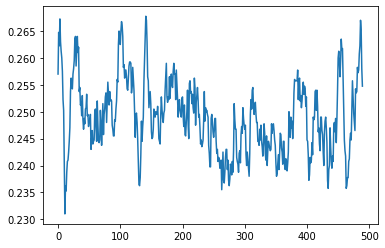

In [147]:
evacc = evsc[:,:,nmaps:].mean((0,2))
plt.plot(mov_avg(evacc,10))

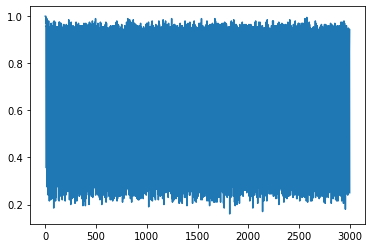

In [144]:
plt.plot(evsc[:,:,:].mean((0)).flatten())

# train acc

### load tracc of group, save in single np arr

In [83]:
nm,ts = 4,0
emL,ntrL,trlL = [0,1],[1,2],[20,30,40]

In [84]:
from glob import glob as glob
import itertools
fdir = 'model_data/amtask-sweep1/'

for em,ntr,trl in itertools.product(emL,ntrL,trlL):
  L = []
  for seed in range(20):
    fpath = 'lstm_20-em_%s-nmaps_%s-ntrials_%s-trlen_%s-ntoksurp_%s-seed_%s-trsc.npy'%(em,nm,ntr,trl,ts,seed)
    try:
      tracc = np.load(fdir+fpath).mean((1,2)) # tr,trlen
      L.append(tracc)
    except:
      continue
  fpath_save = 'lstm_20-em_%s-nmaps_%s-ntrials_%s-trlen_%s-ntoksurp_%s-group-tracc.npy'%(em,nm,ntr,trl,ts)
  try:
    np.save('model_data/amtask-sweep1_analysis/tracc/'+fpath_save,np.stack(L))
  except:
    print('err saving',fpath_save)
    continue

err saving lstm_20-em_0-nmaps_4-ntrials_1-trlen_30-ntoksurp_0-group-tracc.npy
err saving lstm_20-em_1-nmaps_4-ntrials_1-trlen_30-ntoksurp_0-group-tracc.npy


### analyze tracc

In [ ]:
''' sample tracc dataframe '''

# import pandas as pd

# cols = ['acc','lstm1','lstm2','ntrials','seed']
# df = pd.DataFrame(columns=cols)
# data_dict = {}

# fdir = 'model_data/dual_lstms_sweep1/'

# stsize1L,stsize2L,ntrialsL,seedL = [15,20,25],[30,40,50],[1,2,3],np.arange(20)
# for stsize1,stsize2,ntrials,seed in itertools.product(stsize1L,stsize2L,ntrialsL,seedL):
#   fpath = fdir+"lstm1_%i-lstm2_%i-ntrials_%i-seed_%i-tracc.npy" %(stsize1,stsize2,ntrials,seed)
#   try:
#     tracc = np.load(fpath)
#   except:
#     continue
#   acc = tracc[-10000:].mean()
#   df_ = pd.DataFrame(np.array([[acc,stsize1,stsize2,ntrials,seed]]),columns=cols)
#   df = df.append(df_)
  

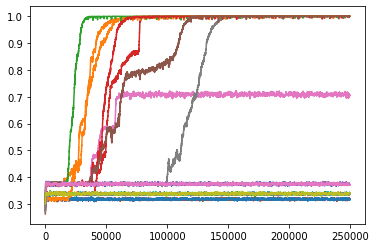

In [96]:
for fpath in fpathL:
  ac = np.load(fpath).mean((1,2))
  plt.plot(mov_avg(ac,500))


# train and eval

In [2]:

def run_net(net,task,neps,ntrials,trlen,training=True):
  '''
  returns score [neps,ntrials,nmaps+trlen]
  '''
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  exp_len = ntrials*(task.nmaps+trlen)
  score = -np.ones([neps,exp_len])
  for ep in range(neps):
    # forward prop
    iseq,xseq,ytarget = task.gen_ep_data(ntrials,trlen)
    yhat_ulog = net(iseq,xseq)
    # eval
    score_t = (maxsoftmax(yhat_ulog) == ytarget).numpy()
    score[ep] = np.squeeze(score_t)
    if training:
      loss = 0
      for tstep in range(len(iseq)):
        loss += lossop(yhat_ulog[tstep],ytarget[tstep])
      optiop.zero_grad()
      loss.backward(retain_graph=True)
      optiop.step()
  score = score.reshape(neps,ntrials,trlen+task.nmaps)
  return score

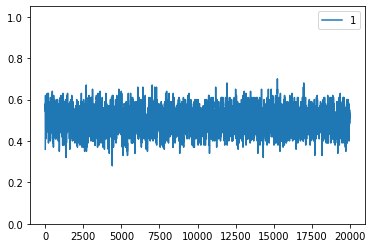

In [48]:
## seed = np.random.randint(99)
# task
nmaps = 2
ntokens_surplus = 0
switchmaps = 1
# net
stsize = 30

neps = 20000
ntrials,trlen=1,10
for em in [1]:
  task = TaskArbitraryMaps(nmaps=nmaps,
                           switchmaps=1,
                           ntokens_surplus=0,
                           seed=seed)
  net = NetAMEM(stsize=stsize,
                emsetting=em,
                wmsetting=1,
                seed=seed)
  trsc = run_net(net,task,neps,ntrials,trlen,training=True)
  tracc = trsc[:,:,nmaps:].mean((1,2))
  plt.plot(mov_avg(tracc,10),label=em)
  
plt.ylim(0,1.05)
plt.legend()

In [29]:
ntr,trl,nm = 2,4,2
task = TaskArbitraryMaps(nmaps=nm,switchmaps=1,ntokens_surplus=0,seed=0)


In [42]:
iseq,xseq,yseq = task.gen_ep_data(ntr,trl)
a = iseq[:,:].reshape(ntr,trl+nm)
b = xseq[:,:,0].reshape(ntr,trl+nm)
c = yseq.reshape(ntr,trl+nm)
for i,j,k  in zip(a.flatten(),b.flatten(),c.flatten()):
  print(i,j,k)


tensor(1) tensor(0.5488) tensor(1)
tensor(2) tensor(0.8918) tensor(2)
tensor(0) tensor(0.5488) tensor(1)
tensor(0) tensor(0.5488) tensor(1)
tensor(0) tensor(0.8918) tensor(2)
tensor(0) tensor(0.8918) tensor(2)
tensor(2) tensor(0.5488) tensor(2)
tensor(1) tensor(0.8918) tensor(1)
tensor(0) tensor(0.8918) tensor(1)
tensor(0) tensor(0.5488) tensor(2)
tensor(0) tensor(0.8918) tensor(1)
tensor(0) tensor(0.8918) tensor(1)


In [33]:
net = NetAMEM(stsize=stsize,emsetting=em,wmsetting=1,seed=seed)

In [43]:
yh = net(iseq,xseq)

0 tensor([1]) tensor(0.5488)
1 tensor([2]) tensor(0.8918)
2 tensor([0]) tensor(0.5488)
3 tensor([0]) tensor(0.5488)
4 tensor([0]) tensor(0.8918)
5 tensor([0]) tensor(0.8918)
6 tensor([2]) tensor(0.5488)
7 tensor([1]) tensor(0.8918)
8 tensor([0]) tensor(0.8918)
9 tensor([0]) tensor(0.5488)
10 tensor([0]) tensor(0.8918)
11 tensor([0]) tensor(0.8918)


In [5]:
'''eval'''
# ntrials_ev,trlen_ev = 20,5
# neps_ev = 200
# evsc = run_net(net,task,neps_ev,ntrials_ev,trlen_ev,training=False)
# block_acc = evsc[:,:,task.nmaps:].mean((0,2))
# plt.plot(block_acc)

# evsc = evsc.reshape(neps_ev,ntrials_ev,trlen_ev+task.nmaps)
# print(evsc.shape)
# evacc = evsc[:,:,task.nmaps:].mean((0,2))
# plt.plot(evacc)
# task.nmaps